# Preprocessing - CONDA Dataset

**Jonathan Gil**

# CONDA Preprocessing Pipeline Description

This Python Notebook contains the code and notes to preprocess the **CONDA** dataset from **https://github.com/usydnlp/CONDA**.

## What does it do?
- Text cleaning (lowercase, URL removal,`[SEPA]` removal, etc.)
- Tokenization, stopword removal, lemmatization with **NLTK**
- TF-IDF vectorization using **scikit-learn**
- Dataset overview visuals:
  - Toxic vs Non-Toxic ratio (Pie Chart)
  - Message word counts distribution (Histogram)
- TF-IDF feature summary

## Input
This notebook uses an annotated CSV that must contain these columns:
- `utterance`: the chat message text
- `intentClass`: one of `E, I, A, O`

**Binary Mapping:**
- Toxic (1): `E` or `I`
- Non-Toxic (0): `A` or `O`


## Requirements:
- First, create a conda environment: 
  - conda create -n ml_project python=3.10 -y
  - conda activate ml_project
- Next, install the dependencies required for this project to work:
  - pip install -r requirements.txt
- Finally, run the preprocessing.ipynb Python Notebook.

## Outputs
- `preprocessing_outputs/reports/tfidf_feature_summary.csv` – idf stats for each feature
- `preprocessing_outputs/reports/toxicity_ratio_pie.png` – pie chart for toxic vs non-toxic counts
- `preprocessing_outputs/reports/word_counts_hist.png` – histogram of message word counts
- `preprocessing_outputs/conda_cleaned_binary.csv` - finalized csv for dataset
- `preprocessing_outputs/features/X_tfidf.npz` – TF-IDF matrix saved
- `preprocessing_outputs/features/y.npy` – labels saved
- `preprocessing_outputs/models/tfidf_vectorizer.joblib` – fitted vectorizer

## 0) Set Paths for Directories

In [1]:
INPUT_CSV_PATH = "../data/conda_train.csv"  # This is our annotated csv for preprocessing
OUTPUT_DIR      = "../with_chat_time/preprocessing_outputs"

# Not sure if I should keep these three directories separate
REPORTS_DIR     = f"{OUTPUT_DIR}/reports" 
FEATURES_DIR    = f"{OUTPUT_DIR}/features"
MODELS_DIR      = f"{OUTPUT_DIR}/models"
FINAL_CLEANED_CSV = f"{OUTPUT_DIR}/final_cleaned_dataset" # might not need this

import os
for d in [OUTPUT_DIR, REPORTS_DIR, FEATURES_DIR, MODELS_DIR]:
    os.makedirs(d, exist_ok=True)

print("Using input: ", INPUT_CSV_PATH)
print("Outputs: ", OUTPUT_DIR)

Using input:  ../data/conda_train.csv
Outputs:  ../with_chat_time/preprocessing_outputs


## 1) Imports (+NLTK)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from joblib import dump

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import re
from typing import List


## 2) Load the Data

We're also going to clean the data and drop non-essential rows.

In [ ]:
# Load the data as DataFrame
data_frame = pd.read_csv(INPUT_CSV_PATH)

# Check for required columns
essential_columns = {'utterance', 'intentClass'} 
missing = essential_columns - set(data_frame.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Prints state of data BEFORE cleaning
display(data_frame.head())
num_rows_before = len(data_frame)
print("Rows before cleaning:", num_rows_before)

# Remove rows with missing essential columns (utterance/intentClass)
data_frame = data_frame.dropna(subset=['utterance', 'intentClass']).copy()

# Prints state of data AFTER cleaning
display(data_frame.head())
num_rows_after = len(data_frame)
print("Rows after cleaning:", num_rows_after)

print(f"\nNumber of rows dropped: {num_rows_before - num_rows_after}")

,Id,matchId,conversationId,utterance,chatTime,playerSlot,playerId,intentClass,slotClasses,slotTokens
0,11263,697,3193,wow!,76,0,ANTS IN MY EYES JOHNSON,O,O,"wow (O),"
1,13741,843,3809,WTF,1563,5,M.k,O,T,"WTF (T),"
2,22125,1412,6199,wpe wpe,2853,1,Acqua Ragia,O,O O,"wpe (O), wpe (O),"
3,6453,439,1875,hahaha,1038,0,juicebox,O,O,"hahaha (O),"
4,9644,601,2713,wtf,1661,5,KAIST.Shadows,O,T,"wtf (T),"


Rows before cleaning: 26921


,Id,matchId,conversationId,utterance,chatTime,playerSlot,playerId,intentClass,slotClasses,slotTokens
0,11263,697,3193,wow!,76,0,ANTS IN MY EYES JOHNSON,O,O,"wow (O),"
1,13741,843,3809,WTF,1563,5,M.k,O,T,"WTF (T),"
2,22125,1412,6199,wpe wpe,2853,1,Acqua Ragia,O,O O,"wpe (O), wpe (O),"
3,6453,439,1875,hahaha,1038,0,juicebox,O,O,"hahaha (O),"
4,9644,601,2713,wtf,1661,5,KAIST.Shadows,O,T,"wtf (T),"


Rows after cleaning: 26914

Number of rows dropped: 7


## 3) Mapping Binary Labels

We are essentially flattening the labels on the datapoints so that we are left with either toxic/non-toxic.

In [ ]:
# We're using set because it has fast lookup time - O(1) time complexity.
# Lists work too but is generally slower for large data.
toxic_set = set(["E","I"])
non_toxic_set = set(["A","O"])


# Since we want to use binary labels, we need to map the text label (intent) to binary (0/1). 
def to_binary(intent):
    if intent in toxic_set:
        return 1
    elif intent in non_toxic_set:
        return 0
    else:
        # Return 'not a number' for unknown intents
        return np.nan 

# Takes each value from intentClass column and sends to 'to_binary' function.
# Creates new column 'is_toxic' for binary labels.
data_frame['is_toxic'] = data_frame['intentClass'].apply(to_binary)

# Keep track of original number of rows before dropping unknown intents
number_of_rows_before = len(data_frame)

# Drops rows for columns with NaN
data_frame = data_frame.dropna(subset=['is_toxic'])

# Not required but converting float to int for binary labels since model expects integer labels for classification
data_frame['is_toxic'] = data_frame['is_toxic'].astype(int)
print(f"Dropped {number_of_rows_before - len(data_frame)} rows with NaN.\nFinal number of rows: {len(data_frame)}")

# Verify chatTime is still in the dataframe
assert 'chatTime' in data_frame.columns, "ERROR: chatTime column was dropped from dataframe!"
print(f"✓ chatTime column verified: {data_frame['chatTime'].notna().sum()} non-null values")

#Displays full dataframe and dataframe with just essential columns
display(data_frame.head(10))
display(data_frame[['utterance','intentClass','is_toxic','chatTime']].head(10))

Dropped 0 rows with NaN.
Final number of rows: 26914


,Id,matchId,conversationId,utterance,chatTime,playerSlot,playerId,intentClass,slotClasses,slotTokens,is_toxic
0,11263,697,3193,wow!,76,0,ANTS IN MY EYES JOHNSON,O,O,"wow (O),",0
1,13741,843,3809,WTF,1563,5,M.k,O,T,"WTF (T),",0
2,22125,1412,6199,wpe wpe,2853,1,Acqua Ragia,O,O O,"wpe (O), wpe (O),",0
3,6453,439,1875,hahaha,1038,0,juicebox,O,O,"hahaha (O),",0
4,9644,601,2713,wtf,1661,5,KAIST.Shadows,O,T,"wtf (T),",0
5,6208,433,1836,i cant [SEPA] play [SEPA] with 4 trash,1674,6,Vintage <3,E,P O SEPA O SEPA O O O,"i (P), cant (O), [SEPA] (SEPA), play (O), [SEP...",1
6,38968,2572,10979,bg,2875,8,Sirotax,O,O,"bg (O),",0
7,3213,240,999,=) [SEPA] ty,1797,1,Иром,O,O,"#ERROR! (O),",0
8,44326,3001,12737,gg [SEPA] report my team rat [SEPA] please,2602,7,ArielexD_Pro!!!,A,S SEPA S P O S SEPA O,"gg (S), [SEPA] (SEPA), report (S), my (P), tea...",0
9,30888,2020,8676,ez mid,3044,8,Hanhan/~,I,S S,"ez (S), mid (S),",1


,utterance,intentClass,is_toxic
0,wow!,O,0
1,WTF,O,0
2,wpe wpe,O,0
3,hahaha,O,0
4,wtf,O,0
5,i cant [SEPA] play [SEPA] with 4 trash,E,1
6,bg,O,0
7,=) [SEPA] ty,O,0
8,gg [SEPA] report my team rat [SEPA] please,A,0
9,ez mid,I,1


## 4) Text preprocessing

1. Tokenize - Break the string into individual words/tokens
2. Stopword Removal - Remove common words that don't add meaning, like "the", "is", "a"
3. Lemmatize - Reduce each word to base/dictionary form, like "Playing/Played/Plays" -> "Play/Play/Play"

THIS IS THE MOST IMPORTANT STEP IN OUR PREPROCESSING PIPELINE!!!


In [5]:
'''
Cleans text by removing: [SEPA], URLs, extra spaces, etc.
.astype(str) makes sure every value is string because preprocessing function 'preprocess_text' will crash on non-string values.
Utilizes 'preprocess_text' function from 'preprocess_utils.py' to clean text.
'''

def preprocess_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    
    # Cleans the text
    text = text.lower() # Lowercase
    text = text.replace("[sepa]", " ") # Remove [SEPA]
    text = re.sub(r"http[s]?://\S+", " ", text) # Remove URLs
    text = re.sub(r"@\w+", " ", text) # Remove user mentions
    text = re.sub(r"[^a-z0-9\s\.\,\!\?\-']", " ", text) # Remove non-essential characters
    text = re.sub(r"\s+", " ", text).strip() # Remove extra spaces

    # Tokenize, remove stopwords, & lemmatize
    tokens = word_tokenize(text)
    stops = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    clean_tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stops]

    return " ".join(clean_tokens)

# Calls 'preprocess_text' function on each utterance and saves cleaned text to new column 'utterance_cleaned'
data_frame['utterance_cleaned'] = data_frame['utterance'].astype(str).map(preprocess_text)
display(data_frame[['utterance','utterance_cleaned']].head(10))

,utterance,utterance_cleaned
0,wow!,wow !
1,WTF,wtf
2,wpe wpe,wpe wpe
3,hahaha,hahaha
4,wtf,wtf
5,i cant [SEPA] play [SEPA] with 4 trash,cant play 4 trash
6,bg,bg
7,=) [SEPA] ty,ty
8,gg [SEPA] report my team rat [SEPA] please,gg report team rat please
9,ez mid,ez mid


## 5) Dataset overview charts

- Toxic vs Non-toxic Pie Chart
- Word Count Histogram

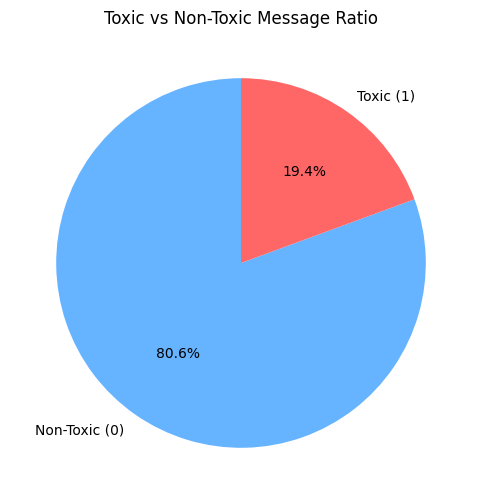

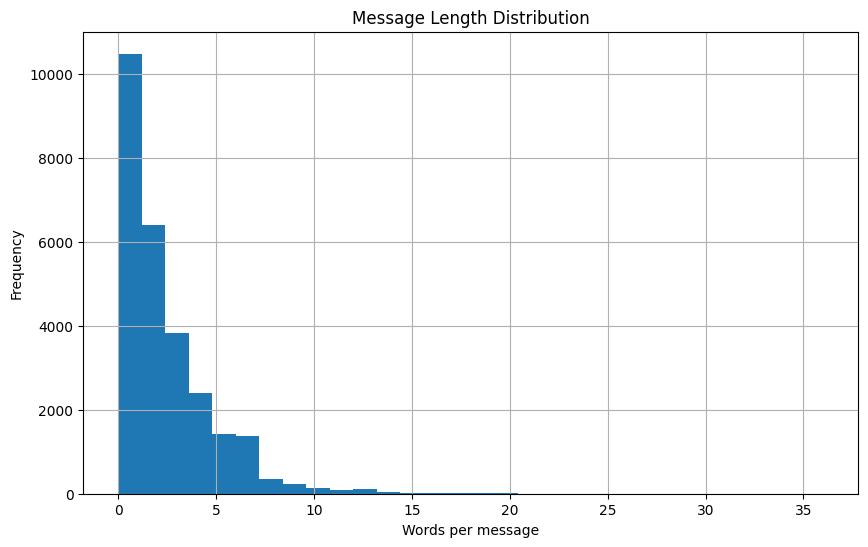

In [6]:
# Count number of toxic messages
counts = data_frame['is_toxic'].value_counts().sort_index()

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    counts,
    labels=["Non-Toxic (0)", "Toxic (1)"],
    autopct='%1.1f%%',   
    startangle=90,  
    colors=["#66b3ff", "#ff6666"],
)
plt.title("Toxic vs Non-Toxic Message Ratio")

# Save the pie chart BEFORE showing
plt.savefig(f"{REPORTS_DIR}/toxicity_ratio_pie.png", dpi=200, bbox_inches='tight')
plt.show()

# Create the word count histogram
# Splits each cleaned utterance into words and counts how many are in each list.
word_counts = data_frame['utterance_cleaned'].str.split().map(len)
# Create a new figure for the histogram
plt.figure(figsize=(10, 6))
# Plots the histogram
word_counts.hist(bins=30)
plt.xlabel("Words per message")
plt.ylabel("Frequency")
plt.title("Message Length Distribution")

# Save the histogram
plt.savefig(f"{REPORTS_DIR}/word_counts_hist.png", dpi=200, bbox_inches='tight')
plt.show()


## 6) TF-IDF Vectorization

Converts cleaned text into numbers that ML models can use

In [7]:
# Create TF-IDF vectorizer with specified parameters
vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    max_df=0.98,
    strip_accents='unicode'
)

# Transform cleaned utterances into TF-IDF features
X = vectorizer.fit_transform(data_frame['utterance_cleaned'])
print("TF-IDF shape:", X.shape)

# Target labels -> Gets binary labels as NumPy array (used for model training)
y = data_frame['is_toxic'].values

# Saving features as .npz and labels as .npy to preprocessing_outputs/features
# .npz is optimized for large/sparse matrices
# .npy is better for smaller/dense arrays
sparse.save_npz(f"{FEATURES_DIR}/X_tfidf.npz", X)
np.save(f"{FEATURES_DIR}/y.npy", y)

# Save TF-IDF vectorizer to preprocessing_outputs/models
# .joblib is efficient for storing scikit-learn models and large numpy arrays
dump(vectorizer, f"{MODELS_DIR}/tfidf_vectorizer.joblib")

TF-IDF shape: (26914, 6171)


['../with_chat_time/preprocessing_outputs/models/tfidf_vectorizer.joblib']

## 7) TF-IDF Feature Summary (IDF stats)

In [8]:
# Stores unique words that TF-IDF vectorizer learned
features = np.array(vectorizer.get_feature_names_out())

# Stores TF-IDF score for each feature.
# IDF measures how rare/informative a word is across the dataset.
# High IDF = rare word -> important
# Low IDF = common word -> superfluous
idfs = vectorizer.idf_

# Create summary DataFrame and save as .csv in preprocessing_outputs/reports
summary = pd.DataFrame({'feature': features, 'idf': idfs}).sort_values('idf', ascending=False)
summary.to_csv(f"{REPORTS_DIR}/tfidf_feature_summary.csv", index=False)

display(summary.head(10))
display(summary.tail(10))

,feature,idf
0,00,10.101827
3381,mby,10.101827
3311,lul,10.101827
3318,lyfe,10.101827
3323,maby,10.101827
3325,mad bro,10.101827
3326,mad kid,10.101827
3328,mad son,10.101827
3329,madafaka,10.101827
3331,maen,10.101827


,feature,idf
3428,mid,4.942771
3756,noob,4.940858
1863,fuck,4.912580
2438,haha,4.788621
2003,game,4.612889
5974,wp,4.610138
4421,report,4.579033
1574,ez,4.121255
3173,lol,3.952646
2129,gg,3.365255


## 8) Save finalized cleaned CSV 

In [ ]:
# Creates and saves finalized cleaned CSV as conda_cleaned_binary.csv
# Verify chatTime is still present before saving
assert 'chatTime' in data_frame.columns, "ERROR: chatTime column missing before saving CSV!"
print(f"✓ Final verification: chatTime column present with {data_frame['chatTime'].notna().sum()} non-null values")

out_csv = f"{OUTPUT_DIR}/conda_cleaned_binary_with_chat_time.csv"
df_out = data_frame[['utterance','utterance_cleaned','intentClass','is_toxic','chatTime']].copy()

# Final check on output dataframe
assert 'chatTime' in df_out.columns, "ERROR: chatTime not included in output CSV!"
print(f"✓ Output CSV will contain chatTime column")

df_out.to_csv(out_csv, index=False)
print(f"✓ Saved CSV with chatTime to: {out_csv}")
display(df_out.head(10))

,utterance,utterance_cleaned,intentClass,is_toxic,chatTime
0,wow!,wow !,O,0,76
1,WTF,wtf,O,0,1563
2,wpe wpe,wpe wpe,O,0,2853
3,hahaha,hahaha,O,0,1038
4,wtf,wtf,O,0,1661
5,i cant [SEPA] play [SEPA] with 4 trash,cant play 4 trash,E,1,1674
6,bg,bg,O,0,2875
7,=) [SEPA] ty,ty,O,0,1797
8,gg [SEPA] report my team rat [SEPA] please,gg report team rat please,A,0,2602
9,ez mid,ez mid,I,1,3044
